In [1]:
from utils import plotcfg
from utils.ML2.utils import *

# 4.0 Implementation

## 4.1 Data Collection

dpi trajectories, different load and idfferent velocity scaling. 

## 4.2 Input and data preprocessing

## 4.3 Hyper parameter optimization

optuna was used to find the best performing hyper parmaters, this uses a random search and early pruning. results of optuna. 

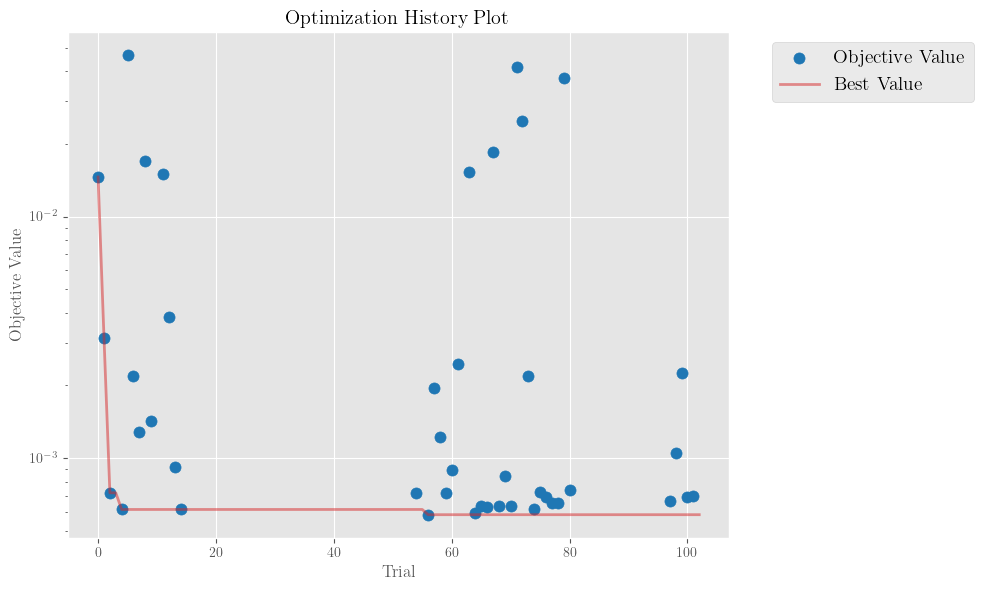

In [5]:
import optuna
import matplotlib.pyplot as plt
study = optuna.study.load_study(study_name = "study_20240702_134134",storage="sqlite:///utils/ML2/optuna_study.db");
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.yscale('log')
plt.tight_layout()

## 4.4 Training

now training, loading preloaded values. 

In [2]:
import os
import torch 

file_path = "utils/ML2/models/model.pt"
if os.path.exists(file_path):
    print("using pre-trained model")
    model = torch.jit.load('utils/ML2/models/model.pt', map_location=torch.device('cpu'))

else:
    pass

using pre-trained model


## 4.5 Results

results are this, looks ok, kinda good performance. 

100%|██████████| 70247/70247 [36:12<00:00, 32.33it/s] 


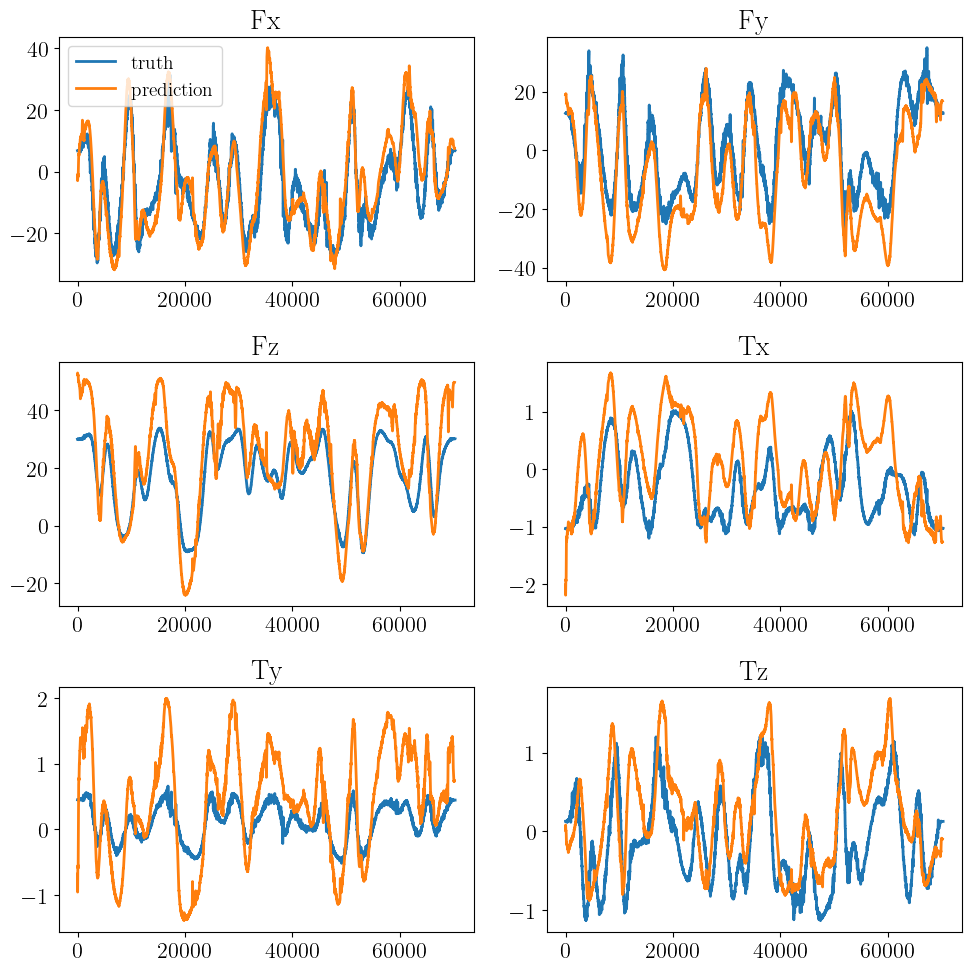

In [5]:
#to denormalize the predictions
y_max = torch.load('utils/ML2/models/y_max.pt',map_location=torch.device('cpu'))
y_min = torch.load('utils/ML2/models/y_min.pt',map_location=torch.device('cpu'))

dataset = CustomDatasetFromCSV(csv_path = 'utils/ML2/validation.csv', mode="test")
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()

pred_list = []
with torch.no_grad():    
    for i, (X,y) in enumerate(tqdm(test_dataloader)):
        
        pred = model(X)
        pred = (pred+1)/2* (y_max - y_min) + y_min
        pred_list.append(pred)

#denormalize the data

y_truth = ((test_dataloader.dataset.y + 1)/2* (y_max - y_min) + y_min).cpu().numpy()
pred_list = torch.cat(pred_list).numpy()
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plotting each component
components = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']
for i, ax in enumerate(axes.flat):
    if i < y_truth.shape[1]:  # Ensure there are enough columns to plot
        ax.plot(y_truth[:, i], label="truth")
        ax.plot(pred_list[:, i], label="prediction")
        ax.set_title(components[i])
    else:
        ax.set_visible(False)

# Add legend to the first subplot
axes[0, 0].legend()
# Display the plot
plt.tight_layout()
plt.show()


In [6]:

def dh_transform(a, alpha, d, theta):
    """
    Compute Denavit-Hartenberg transformation matrix.
    """
    return np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,             np.sin(alpha),                 np.cos(alpha),                 d],
        [0,             0,                             0,                             1]
    ])
dh_params = [
    (0, -np.pi/2, 0.26, 0),           # Link 1
    (0.48, 0, 0, -np.pi/2),       # Link 2
    (0, np.pi/2, 0, np.pi/2),        # Link 3
    (0, -np.pi/2, 0.7, 0),          # Link 4
    (0, np.pi/2, 0, 0),              # Link 5
    (0, 0, 0.1735, 0)                 # Link 6
]

def compute_geometric_jacobian(joint_angles,dh_params = dh_params):
    """
    Compute the geometric Jacobian for a robot given DH parameters and joint angles.

    :param dh_params: List of DH parameters [(a, alpha, d, theta), ...]
    :param joint_angles: List of joint angles [theta1, theta2, ..., thetaN]
    :return: Geometric Jacobian matrix (6 x N)
    """
    num_joints = len(joint_angles)
    T = np.eye(4)
    transformations = [T.copy()]
    
    # Compute forward kinematics to get transformations
    for i, (a, alpha, d, theta) in enumerate(dh_params):
        theta += joint_angles[i]  # Update theta with joint angle
        T_i = dh_transform(a, alpha, d, theta)
        T = np.dot(T, T_i)
        transformations.append(T.copy())
    
    # Initialize Jacobian matrix
    jacobian = np.zeros((6, num_joints))
    
    # End-effector position
    T_0_n = transformations[-1]
    o_n = T_0_n[:3, 3]

    # Compute each column of the Jacobian
    for i in range(num_joints):
        T_0_i = transformations[i]
        o_i = T_0_i[:3, 3]
        z_i = T_0_i[:3, 2]

        jacobian[:3, i] = np.cross(z_i, (o_n - o_i))  # Linear part
        jacobian[3:, i] = z_i  # Angular part

    return jacobian


Text(0, 0.5, 'Torque(N.m)')

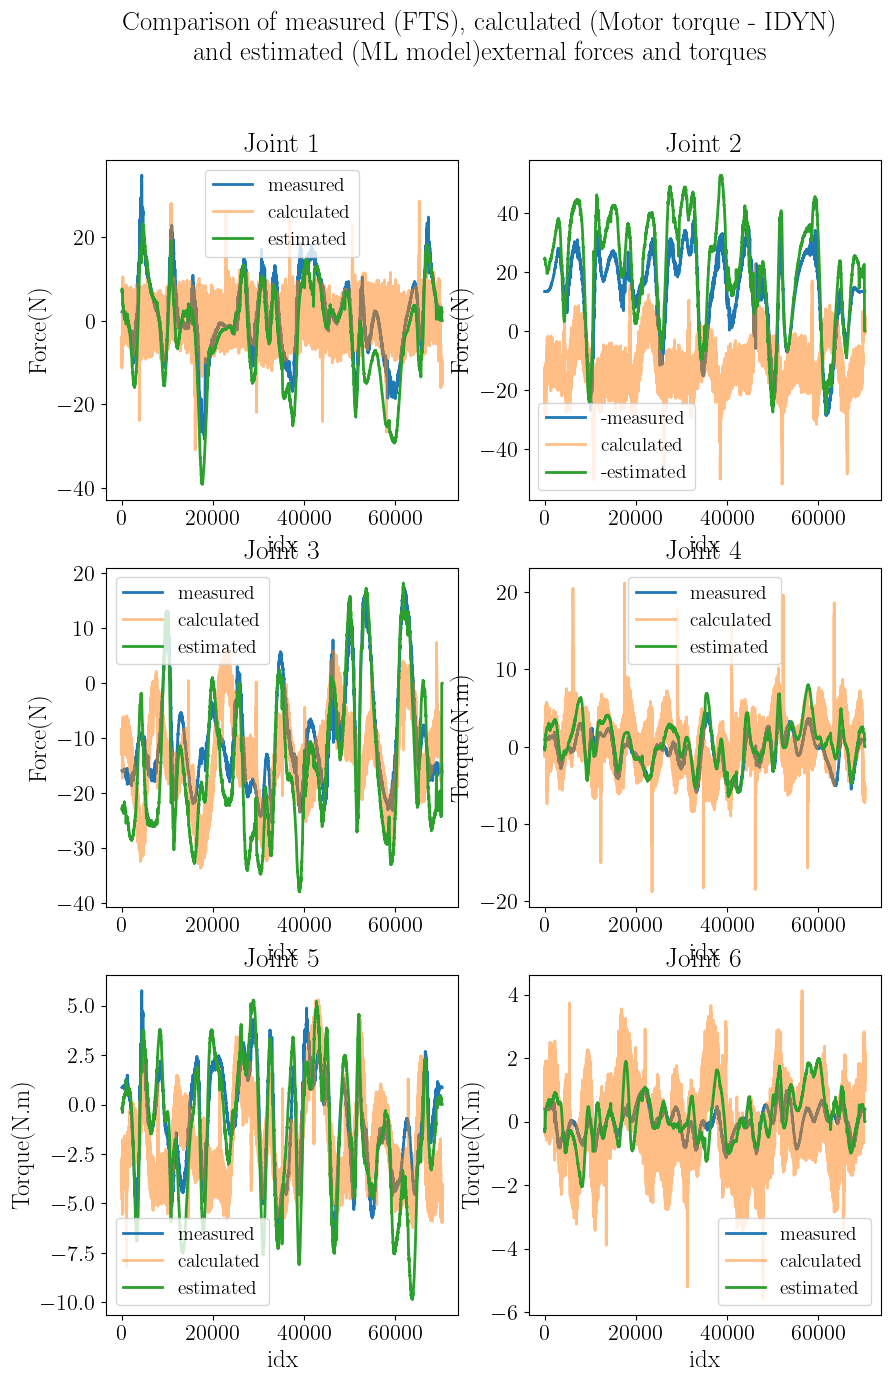

In [8]:
input_df = pd.read_csv('utils/ML2/validation.csv')
pred_df = pd.DataFrame(pred_list, columns = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz'])
#create empty arrays to store the results
measured_external_force = np.zeros((len(input_df),6))
calculated_external_force = np.zeros((len(input_df),6))
estimated_external_force = np.zeros((len(input_df),6))

for i, row in input_df.iterrows():

    joint_angle = row[["joint_angles_1","joint_angles_2","joint_angles_3","joint_angles_4","joint_angles_5","joint_angles_6"]].values
    joint_angle = np.array(joint_angle)
    #print(joint_angle)
    jacobian = compute_geometric_jacobian(joint_angle)
    

    joint_torque = row[["joint_torque_current_1","joint_torque_current_2","joint_torque_current_3","joint_torque_current_4","joint_torque_current_5","joint_torque_current_6"]].values
    joint_torque = np.array(joint_torque)

    idyn_torque = row[["target_joint_torque_1","target_joint_torque_2","target_joint_torque_3","target_joint_torque_4","target_joint_torque_5","target_joint_torque_6"]].values
    idyn_torque = np.array(idyn_torque)
    
    fts_reading = row[["fts_reading_1","fts_reading_2","fts_reading_3","fts_reading_4","fts_reading_5","fts_reading_6"]]
    fts_reading = np.array(fts_reading)
    
    measured_external_force[i] = jacobian.T@fts_reading
    calculated_external_force[i] = joint_torque - idyn_torque
    try:
        estimated_external_force[i] = jacobian.T@pred_df.iloc[i].values # the dropna in the dataset will cause the index to be different could cause shifts in plot
    except Exception as e:
        continue
    

   
#plot the results
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle('Comparison of measured (FTS), calculated (Motor torque - IDYN) \n and estimated (ML model)external forces and torques')
axes[0, 0].plot(measured_external_force[:,0],label="measured")
axes[0, 0].plot(calculated_external_force[:,0],label="calculated",alpha=0.5)
axes[0, 0].plot(estimated_external_force[:,0],label="estimated")
axes[0, 0].set_title('Joint 1')
axes[0, 0].legend()
axes[0, 0].set_xlabel('idx')
axes[0, 0].set_ylabel('Force(N)')

axes[0, 1].plot(-measured_external_force[:,1],label="-measured")
axes[0, 1].plot(calculated_external_force[:,1],label="calculated",alpha=0.5)
axes[0, 1].plot(-estimated_external_force[:,1],label="-estimated")
axes[0, 1].set_title('Joint 2')
axes[0, 1].legend()
axes[0, 1].set_xlabel('idx')
axes[0, 1].set_ylabel('Force(N)')

axes[1, 0].plot(measured_external_force[:,2],label="measured")
axes[1, 0].plot(calculated_external_force[:,2],label="calculated",alpha=0.5)
axes[1, 0].plot(estimated_external_force[:,2],label="estimated")
axes[1, 0].set_title('Joint 3')
axes[1, 0].legend()
axes[1, 0].set_xlabel('idx')
axes[1, 0].set_ylabel('Force(N)')

axes[1, 1].plot(measured_external_force[:,3],label="measured")
axes[1, 1].plot(calculated_external_force[:,3],label="calculated",alpha=0.5)
axes[1, 1].plot(estimated_external_force[:,3],label="estimated")
axes[1, 1].set_title('Joint 4')
axes[1, 1].legend()
axes[1, 1].set_xlabel('idx')
axes[1, 1].set_ylabel('Torque(N.m)')

axes[2, 0].plot(measured_external_force[:,4],label="measured")
axes[2, 0].plot(calculated_external_force[:,4],label="calculated",alpha=0.5)
axes[2, 0].plot(estimated_external_force[:,4],label="estimated")
axes[2, 0].set_title('Joint 5')
axes[2, 0].legend()
axes[2, 0].set_xlabel('idx')
axes[2, 0].set_ylabel('Torque(N.m)')
axes[2, 0].set_xlabel('idx')
axes[2, 0].set_ylabel('Torque(N.m)')

axes[2, 1].plot(measured_external_force[:,5],label="measured")
axes[2, 1].plot(calculated_external_force[:,5],label="calculated",alpha=0.5)
axes[2, 1].plot(estimated_external_force[:,5],label="estimated")
axes[2, 1].set_title('Joint 6')
axes[2, 1].legend()
axes[2, 1].set_xlabel('idx')
axes[2, 1].set_ylabel('Torque(N.m)')
axes[2, 1].set_xlabel('idx')
axes[2, 1].set_ylabel('Torque(N.m)')

## 4.6 Integration

integrated into cpp, tested for inference time, give the inference time here. 